# Satellite Image Classification

The "Satellite Image Classification" dataset on Kaggle is a collection of satellite images labeled with classes such as "Cloudy", "Desert", "Green_Area", and "Water". The data is made up of satellite images of size 256x256, and can be used for computer vision tasks such as image classification.

# Satellite Image Classification Model

---

## Set support functions

In [3]:
def plot_history_curves(history, model_id, opt_name, lr_rate, filt_scl, act_fun):
    """
    Returns separate loss curves for training and validation metrics.
    :param history: history from process of training model.
    :return: plotted separate curves for training and validation.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    dice_score = history.history['accuracy']
    val_dice_score = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    fig, ax = plt.subplots(1, 2, figsize=(13, 6))

    # Plotting loss
    ax[0].plot(epochs, loss, label='training_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].legend()

    # Plotting dice_score
    ax[1].plot(epochs, dice_score, label='training_accuracy')
    ax[1].plot(epochs, val_dice_score, label='val_accuracy')
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()
    fig.suptitle(f"Model_{model_id}")
    fig.tight_layout()
    plt.savefig("/content/figs/opt-{}_lr{}_fscl{}_act-{}_loss_acc_history.png".format(opt_name,
                                                                                      lr_rate,
                                                                                      flt_scl,
                                                                                      act_fun))
    plt.show()

In [4]:
# Unzip dataset file
from zipfile import ZipFile

with ZipFile("/content/archive.zip", 'r') as zipf:
    zipf.extractall(path="/content/")

# GPU Being Used:

In [5]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


# Data Pre-processing:

In [6]:
import pandas as pd
import os

# Create an empty dataframe
data = pd.DataFrame(columns=['image_path', 'label'])

# Define the labels/classes
labels = {'/content/data/cloudy' : 'Cloudy',
          '/content/data/desert' : 'Desert',
          '/content/data/green_area' : 'Green_Area',
          '/content/data/water' : 'Water',
           }

In [7]:
# Loop over the train, test, and val folders and extract the image path and label
for folder in labels:
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        label = labels[folder]
        data = data.append({'image_path': image_path, 'label': label}, ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-7-41271b37954b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-7-41271b37954b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-7-41271b37954b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-7-41271b37954b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'image_

In [8]:
# Save the data to a CSV file
data.to_csv('/content/image_dataset.csv', index=False)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [10]:
# Load the dataset
df = pd.read_csv("/content/image_dataset.csv")

In [11]:
df

,image_path,label
0,/content/data/cloudy/train_8972.jpg,Cloudy
1,/content/data/cloudy/train_19792.jpg,Cloudy
2,/content/data/cloudy/train_30308.jpg,Cloudy
3,/content/data/cloudy/train_13785.jpg,Cloudy
4,/content/data/cloudy/train_1756.jpg,Cloudy
...,...,...
5626,/content/data/water/SeaLake_1576.jpg,Water
5627,/content/data/water/SeaLake_2188.jpg,Water
5628,/content/data/water/SeaLake_1358.jpg,Water
5629,/content/data/water/SeaLake_519.jpg,Water


In [12]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [13]:
# Pre-process the data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    target_size=(255, 255),
                                                    batch_size=32,
                                                    class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(255, 255),
                                                  batch_size=32,
                                                  class_mode="categorical")


Found 4504 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.


# Build Pipeline for Experiments

In [14]:
from keras.optimizers import Optimizer
from keras.models import Model
def get_model(filters_scale: float,
              kernel_size: int,
              activation_fun: str,
              ) -> Model:
    """
    Function for construct the model;
    :param filters_scale: the number of scale that will be multiply with number
    of filters in entry and all hidden layers of the model;
    :param kernel_size: the size of the kernel will be defined in entry and all
    hidden layers of the model;
    :param activation_fun: name of activation function for model layers;
    :return: built Keras model.
    """
    # Build a deep learning model
    model = Sequential()
    model.add(Conv2D(int(32 * filters_scale), kernel_size, input_shape=(255, 255, 3), activation=activation_fun))
    model.add(Conv2D(int(32 * filters_scale), kernel_size, activation=activation_fun, input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(int(64 * filters_scale), kernel_size, activation=activation_fun))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(int(128 * filters_scale), kernel_size, activation=activation_fun))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(int(128 * filters_scale), activation=activation_fun))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    return model

### Prepare table to collecting results of experiments

In [15]:
exp_results_df = pd.DataFrame({"model_id": [],
                               "optimizer": [],
                               "learning_rate": [],
                               "filters_scale": [],
                               "activation_fun": [],
                               "training_time": [],
                               "loss": [],
                               "accuracy": []})

### Prepare Hyperparameters set

In [16]:
from keras.optimizers import Adam, Adamax
# Define optimizer hyperparameter
learning_rates = (0.0001, 0.0007)
optimizers = (Adam, Adamax)

In [17]:
# Define model architecture hyperparameters
filters_scale = (1.5, 2)
kernels_size = 3
activation_fun = ("relu", "tanh")

In [18]:
# Define training hyperparameters
epochs = 5

## Prepare pipeline function to process experiments

In [19]:
import time
import itertools
from keras.utils import plot_model
from PIL import Image

In [49]:
def exp_pipeline(train_gen, test_gen, optimizer, lr_rate, model_ids,
                 epochs, filters_scale, kernels_size, activation_fun):
    """
    To go through experiment pipeline with different hyperparameters,
    save model and results of experiments to file.
    :param train_gen:
    :param test_gen:
    :param optimizer: keras class of optimizing method;
    :param lr_rate: learning rate for optimizer;
    :param model_ids: ;
    :param epochs: ;
    :param filters_scale: ;
    :param kernels_size: ;
    :param acitvation_fun: ;
    """

    opt_name = "optmz"
    if optimizer is Adam:
        opt_name = "adam"
    elif optimizer is Adamax:
        opt_name = "adamax"

    # Define variable time for calculate time of training process
    start = time.time()
    model_id = next(model_ids)
    print(f"Model_{model_id} with:")
    print("\t\t-- optimzer:{} lr_rate:{} --".format(opt_name,
                                                    lr_rate))
    print("\t\t-- filters_scale:{} activation fun:{} --".format(filters_scale,
                                                                activation_fun))

    # Get dl model
    dl_model = get_model(filters_scale, kernels_size, activation_fun)

    # Compile dl model
    dl_model.compile(optimizer=optimizer(learning_rate=lr_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # == Fit model ==
    model_history = dl_model.fit(train_gen, epochs=epochs, validation_data=test_gen)

    training_time = time.time() - start
    print("=== Training duration is %s second ===" % training_time)

    # Plotting history of model training curves
    plot_history_curves(model_history, model_id, opt_name, lr_rate, filters_scale, activation_fun)

    # plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
    # display(Image.open('cnn_model.png'))

    # Evaluate model
    num_samples = test_df.shape[0]
    loss, accuracy = dl_model.evaluate(test_gen,
                                       steps=num_samples//32+1
                                       )

    exp_results_df.loc[len(exp_results_df)] = [f"model_{model_id}",
                                               opt_name,
                                               lr_rate,
                                               filters_scale,
                                               activation_fun,
                                               "%.1f" % training_time,
                                               "%.4f" % loss,
                                               "%.4f" % accuracy]

    # Define model save paths to saving the trained model
    model_save_path = "/content/models/opt-{}_lr{}_fscl{}_act-{}_dl_model.h5".format(opt_name,
                                                                                     lr_rate,
                                                                                     filters_scale,
                                                                                     activation_fun)
    # save it as a h5 file
    dl_model.save(model_save_path)

## Taking experiments with model

Model_0 with:
		-- optimzer:adam lr_rate:0.0001 --
		-- filters_scale:1.5 activation fun:relu --
Epoch 1/5
141/141 [==============================] - 82s 574ms/step - loss: 0.6997 - accuracy: 0.6494 - val_loss: 0.4500 - val_accuracy: 0.8110
Epoch 2/5
141/141 [==============================] - 79s 557ms/step - loss: 0.4241 - accuracy: 0.8230 - val_loss: 0.3611 - val_accuracy: 0.8296
Epoch 3/5
141/141 [==============================] - 78s 554ms/step - loss: 0.3664 - accuracy: 0.8561 - val_loss: 0.3306 - val_accuracy: 0.8589
Epoch 4/5
141/141 [==============================] - 79s 556ms/step - loss: 0.3542 - accuracy: 0.8555 - val_loss: 0.3071 - val_accuracy: 0.8838
Epoch 5/5
141/141 [==============================] - 79s 558ms/step - loss: 0.3240 - accuracy: 0.8606 - val_loss: 0.2971 - val_accuracy: 0.8722
=== Training duration is 410.80648589134216 second ===


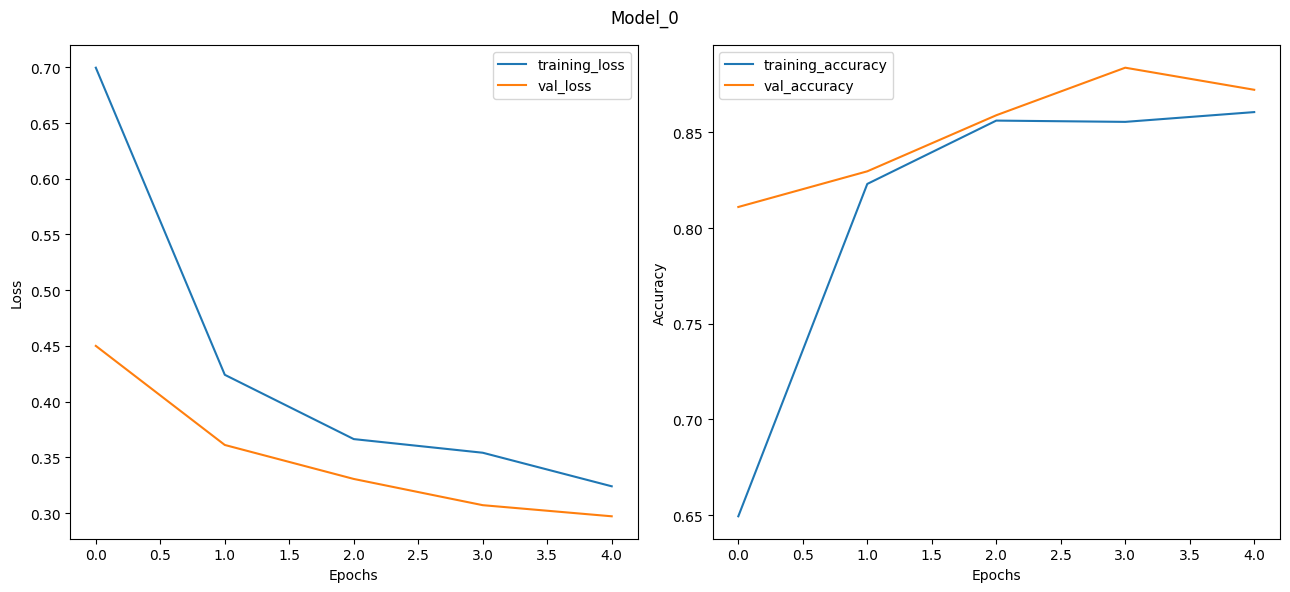

36/36 [==============================] - 3s 74ms/step - loss: 0.2971 - accuracy: 0.8722
Model_1 with:
		-- optimzer:adam lr_rate:0.0001 --
		-- filters_scale:1.5 activation fun:tanh --
Epoch 1/5
141/141 [==============================] - 84s 589ms/step - loss: 0.7154 - accuracy: 0.6936 - val_loss: 0.4250 - val_accuracy: 0.8394
Epoch 2/5
141/141 [==============================] - 82s 584ms/step - loss: 0.4594 - accuracy: 0.7917 - val_loss: 0.4802 - val_accuracy: 0.7409
Epoch 3/5
141/141 [==============================] - 84s 592ms/step - loss: 0.4214 - accuracy: 0.8190 - val_loss: 0.4406 - val_accuracy: 0.7959
Epoch 4/5
141/141 [==============================] - 81s 576ms/step - loss: 0.3771 - accuracy: 0.8470 - val_loss: 0.3952 - val_accuracy: 0.8438
Epoch 5/5
141/141 [==============================] - 81s 572ms/step - loss: 0.3415 - accuracy: 0.8641 - val_loss: 0.5465 - val_accuracy: 0.8030
=== Training duration is 472.1524908542633 second ===


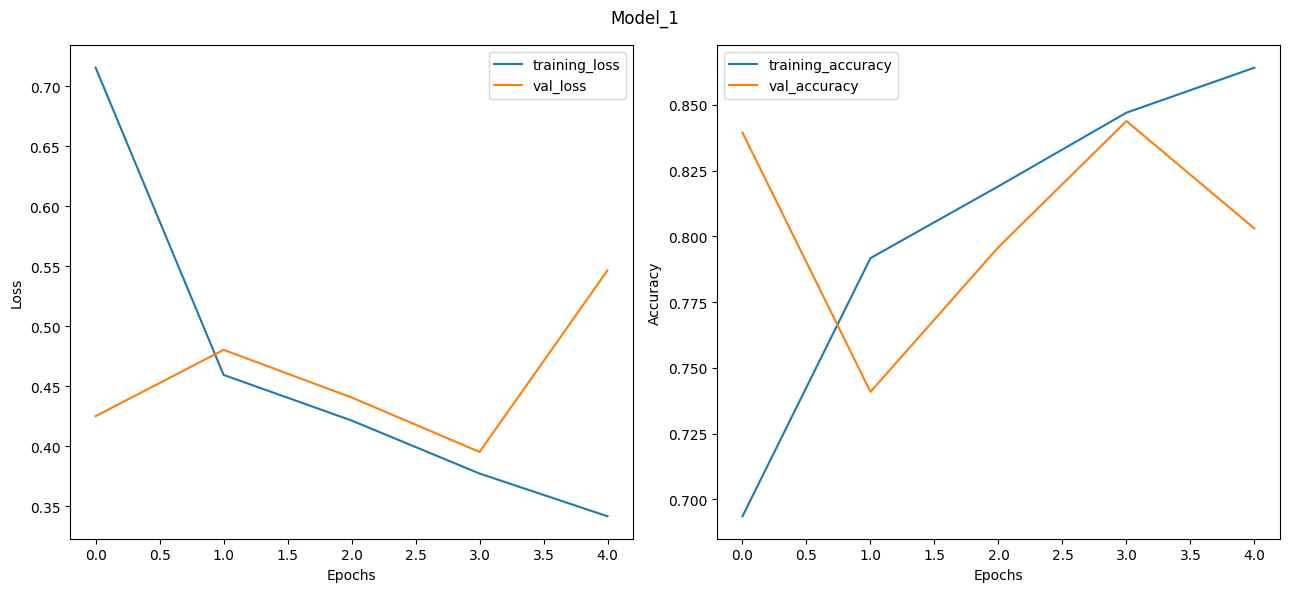

36/36 [==============================] - 3s 88ms/step - loss: 0.5465 - accuracy: 0.8030
Model_2 with:
		-- optimzer:adam lr_rate:0.0001 --
		-- filters_scale:2 activation fun:relu --
Epoch 1/5
141/141 [==============================] - 93s 613ms/step - loss: 0.5958 - accuracy: 0.6996 - val_loss: 0.4062 - val_accuracy: 0.8456
Epoch 2/5
141/141 [==============================] - 81s 573ms/step - loss: 0.4092 - accuracy: 0.8290 - val_loss: 0.3490 - val_accuracy: 0.8571
Epoch 3/5
141/141 [==============================] - 81s 573ms/step - loss: 0.3582 - accuracy: 0.8544 - val_loss: 0.3120 - val_accuracy: 0.8731
Epoch 4/5
141/141 [==============================] - 83s 586ms/step - loss: 0.3548 - accuracy: 0.8555 - val_loss: 0.3030 - val_accuracy: 0.8678
Epoch 5/5
141/141 [==============================] - 82s 584ms/step - loss: 0.3066 - accuracy: 0.8717 - val_loss: 0.2669 - val_accuracy: 0.8891
=== Training duration is 540.6292173862457 second ===


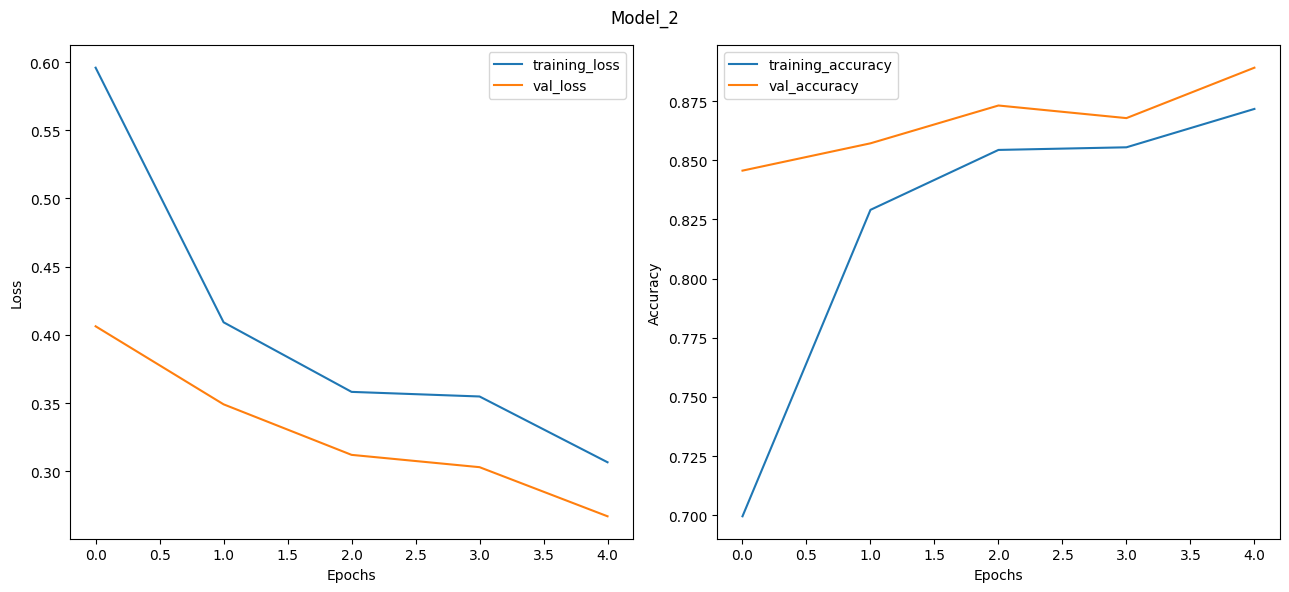

36/36 [==============================] - 3s 78ms/step - loss: 0.2669 - accuracy: 0.8891
Model_3 with:
		-- optimzer:adam lr_rate:0.0001 --
		-- filters_scale:2 activation fun:tanh --
Epoch 1/5
141/141 [==============================] - 90s 618ms/step - loss: 0.7790 - accuracy: 0.6785 - val_loss: 0.5713 - val_accuracy: 0.7835
Epoch 2/5
141/141 [==============================] - 85s 604ms/step - loss: 0.5293 - accuracy: 0.7973 - val_loss: 0.4291 - val_accuracy: 0.8012
Epoch 3/5
141/141 [==============================] - 85s 600ms/step - loss: 0.4592 - accuracy: 0.8175 - val_loss: 0.2900 - val_accuracy: 0.8909
Epoch 4/5
141/141 [==============================] - 85s 601ms/step - loss: 0.4107 - accuracy: 0.8495 - val_loss: 0.4482 - val_accuracy: 0.7862
Epoch 5/5
141/141 [==============================] - 85s 603ms/step - loss: 0.3563 - accuracy: 0.8572 - val_loss: 0.2498 - val_accuracy: 0.9193
=== Training duration is 545.2320656776428 second ===


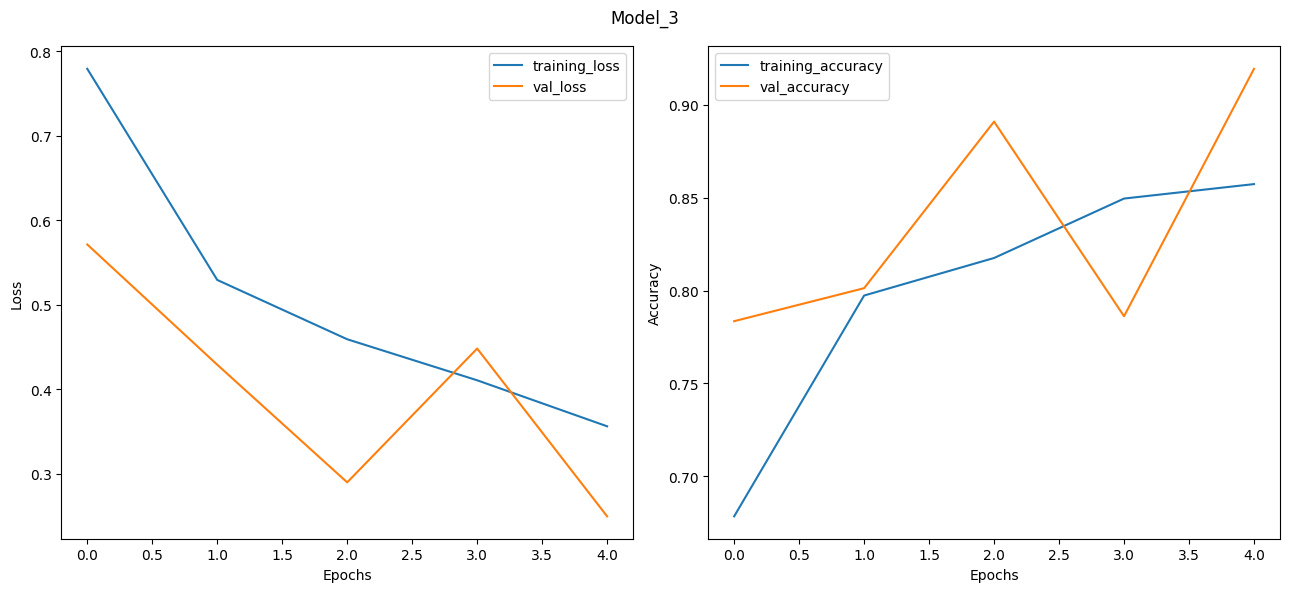

36/36 [==============================] - 4s 96ms/step - loss: 0.2498 - accuracy: 0.9193
Model_4 with:
		-- optimzer:adam lr_rate:0.0007 --
		-- filters_scale:1.5 activation fun:relu --
Epoch 1/5
141/141 [==============================] - 79s 555ms/step - loss: 0.5703 - accuracy: 0.7271 - val_loss: 0.3337 - val_accuracy: 0.8740
Epoch 2/5
141/141 [==============================] - 79s 561ms/step - loss: 0.3694 - accuracy: 0.8555 - val_loss: 0.2909 - val_accuracy: 0.8846
Epoch 3/5
141/141 [==============================] - 79s 562ms/step - loss: 0.3621 - accuracy: 0.8477 - val_loss: 0.3287 - val_accuracy: 0.8634
Epoch 4/5
141/141 [==============================] - 79s 557ms/step - loss: 0.3444 - accuracy: 0.8610 - val_loss: 0.3172 - val_accuracy: 0.8403
Epoch 5/5
141/141 [==============================] - 79s 558ms/step - loss: 0.3131 - accuracy: 0.8710 - val_loss: 0.2990 - val_accuracy: 0.8873
=== Training duration is 402.7037823200226 second ===


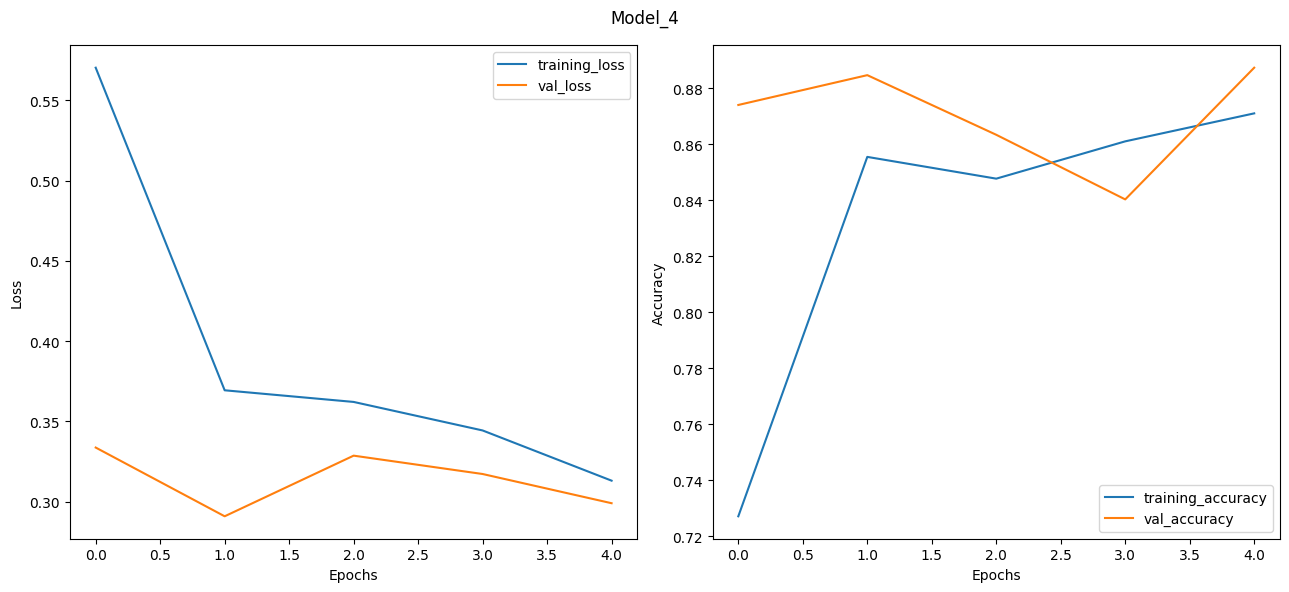

36/36 [==============================] - 3s 82ms/step - loss: 0.2990 - accuracy: 0.8873
Model_5 with:
		-- optimzer:adam lr_rate:0.0007 --
		-- filters_scale:1.5 activation fun:tanh --
Epoch 1/5
141/141 [==============================] - 81s 567ms/step - loss: 1.8970 - accuracy: 0.4443 - val_loss: 0.8105 - val_accuracy: 0.5244
Epoch 2/5
141/141 [==============================] - 80s 565ms/step - loss: 1.1118 - accuracy: 0.5018 - val_loss: 0.7648 - val_accuracy: 0.5847
Epoch 3/5
141/141 [==============================] - 85s 601ms/step - loss: 1.7513 - accuracy: 0.3617 - val_loss: 1.3934 - val_accuracy: 0.2520
Epoch 4/5
141/141 [==============================] - 81s 572ms/step - loss: 1.7070 - accuracy: 0.2593 - val_loss: 1.3886 - val_accuracy: 0.2520
Epoch 5/5
141/141 [==============================] - 83s 586ms/step - loss: 1.6400 - accuracy: 0.2520 - val_loss: 1.3842 - val_accuracy: 0.2910
=== Training duration is 468.9323818683624 second ===


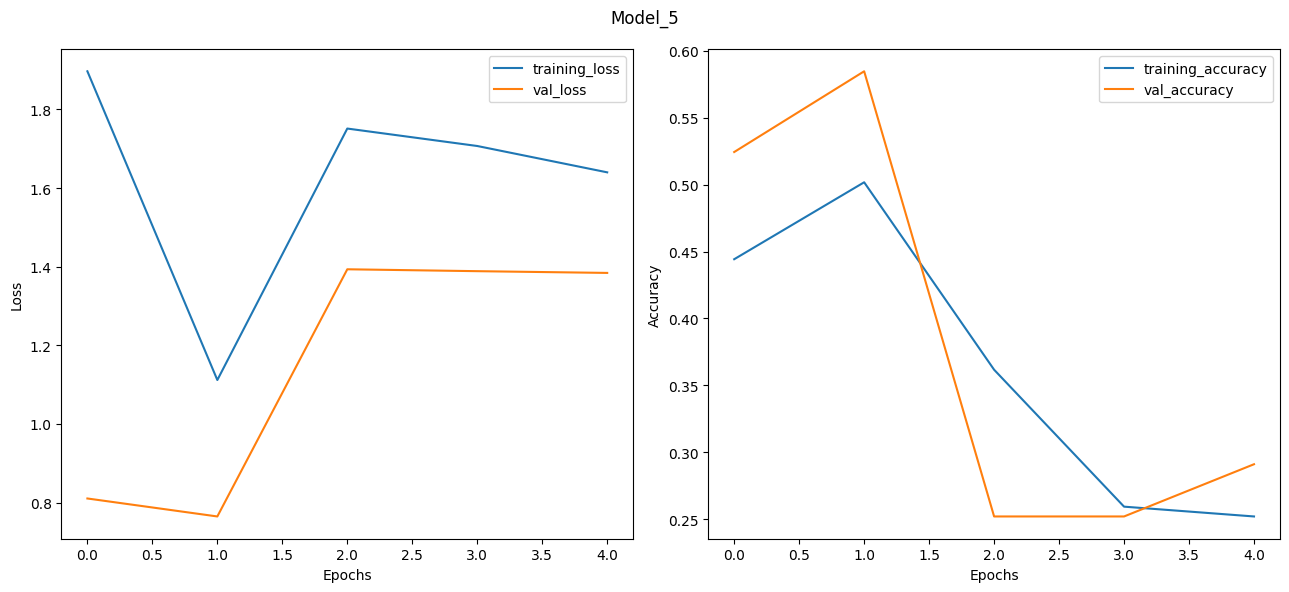

36/36 [==============================] - 3s 84ms/step - loss: 1.3842 - accuracy: 0.2910
Model_6 with:
		-- optimzer:adam lr_rate:0.0007 --
		-- filters_scale:2 activation fun:relu --
Epoch 1/5
141/141 [==============================] - 84s 592ms/step - loss: 0.5947 - accuracy: 0.7367 - val_loss: 0.4496 - val_accuracy: 0.8305
Epoch 2/5
141/141 [==============================] - 83s 585ms/step - loss: 0.4174 - accuracy: 0.8377 - val_loss: 0.3916 - val_accuracy: 0.8341
Epoch 3/5
141/141 [==============================] - 83s 587ms/step - loss: 0.3704 - accuracy: 0.8537 - val_loss: 0.6362 - val_accuracy: 0.7542
Epoch 4/5
141/141 [==============================] - 82s 581ms/step - loss: 0.3891 - accuracy: 0.8572 - val_loss: 0.2976 - val_accuracy: 0.8767
Epoch 5/5
141/141 [==============================] - 83s 583ms/step - loss: 0.3431 - accuracy: 0.8552 - val_loss: 0.5868 - val_accuracy: 0.6788
=== Training duration is 532.5725290775299 second ===


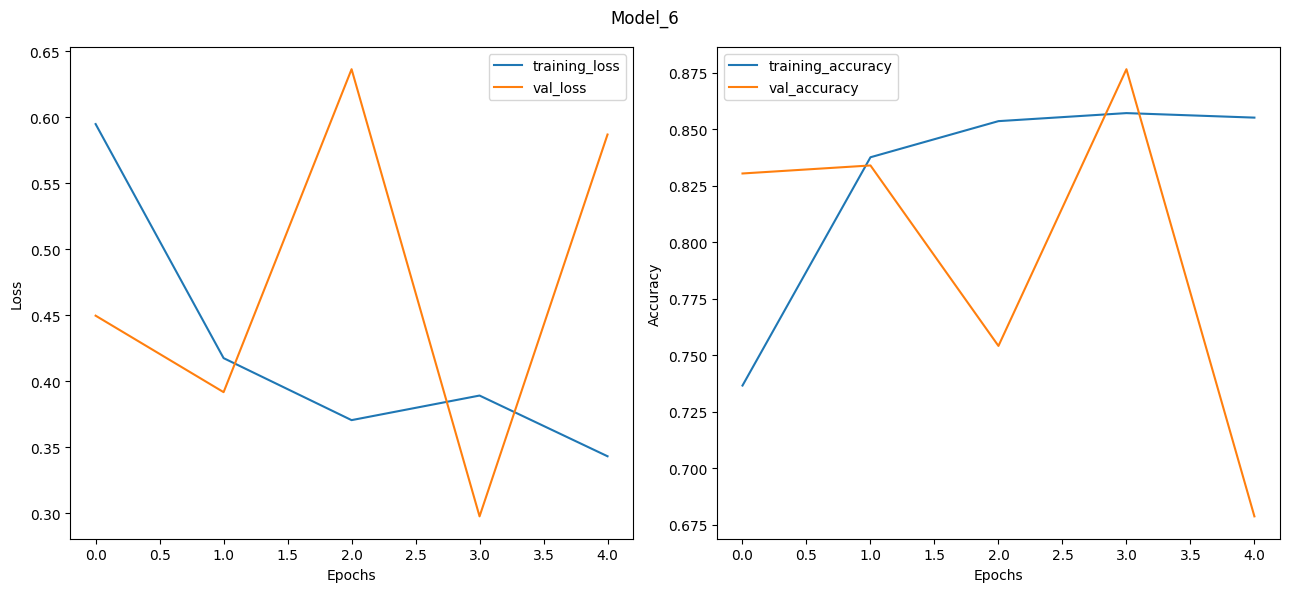

36/36 [==============================] - 3s 93ms/step - loss: 0.5868 - accuracy: 0.6788
Model_7 with:
		-- optimzer:adam lr_rate:0.0007 --
		-- filters_scale:2 activation fun:tanh --
Epoch 1/5
141/141 [==============================] - 86s 608ms/step - loss: 1.9838 - accuracy: 0.4580 - val_loss: 0.7912 - val_accuracy: 0.6158
Epoch 2/5
141/141 [==============================] - 85s 605ms/step - loss: 1.5149 - accuracy: 0.4061 - val_loss: 0.7901 - val_accuracy: 0.4942
Epoch 3/5
141/141 [==============================] - 85s 600ms/step - loss: 1.0278 - accuracy: 0.5140 - val_loss: 0.7515 - val_accuracy: 0.4907
Epoch 4/5
141/141 [==============================] - 86s 606ms/step - loss: 0.9486 - accuracy: 0.5140 - val_loss: 0.7530 - val_accuracy: 0.5670
Epoch 5/5
141/141 [==============================] - 85s 599ms/step - loss: 1.4192 - accuracy: 0.4014 - val_loss: 1.4078 - val_accuracy: 0.2014
=== Training duration is 596.8871564865112 second ===


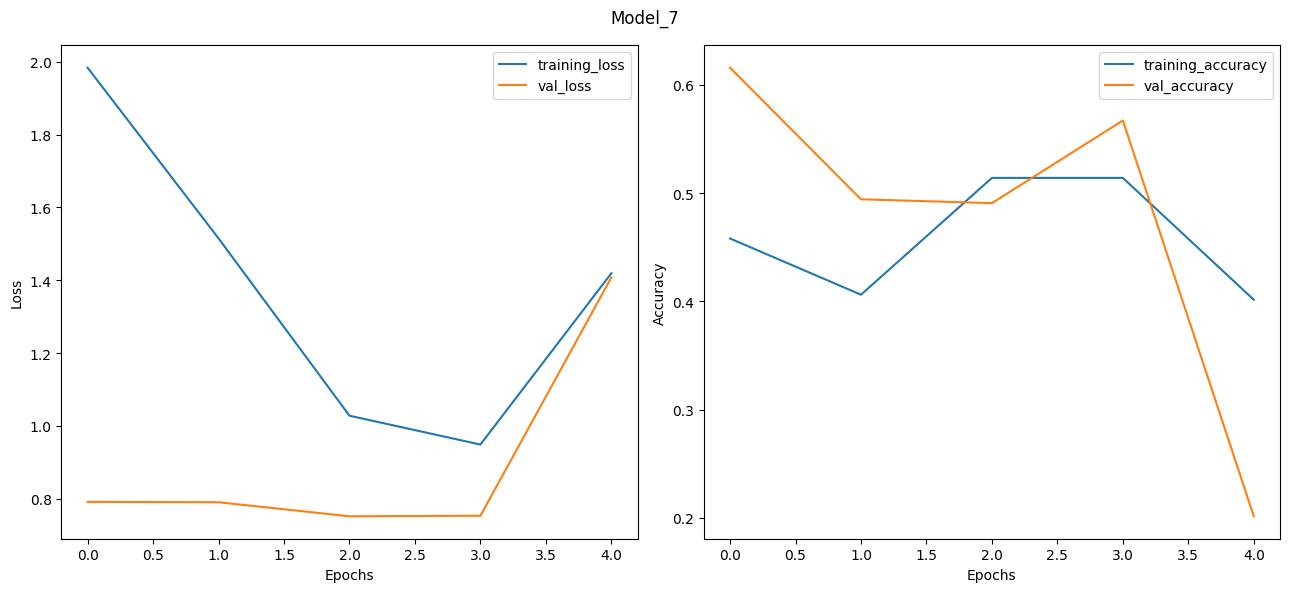

36/36 [==============================] - 4s 106ms/step - loss: 1.4078 - accuracy: 0.2014
Model_8 with:
		-- optimzer:adamax lr_rate:0.0001 --
		-- filters_scale:1.5 activation fun:relu --
Epoch 1/5
141/141 [==============================] - 81s 570ms/step - loss: 0.7843 - accuracy: 0.5999 - val_loss: 0.5165 - val_accuracy: 0.7036
Epoch 2/5
141/141 [==============================] - 80s 565ms/step - loss: 0.5675 - accuracy: 0.6969 - val_loss: 0.4867 - val_accuracy: 0.7223
Epoch 3/5
141/141 [==============================] - 82s 580ms/step - loss: 0.5184 - accuracy: 0.7420 - val_loss: 0.4366 - val_accuracy: 0.8722
Epoch 4/5
141/141 [==============================] - 80s 565ms/step - loss: 0.4768 - accuracy: 0.7824 - val_loss: 0.3858 - val_accuracy: 0.8784
Epoch 5/5
141/141 [==============================] - 81s 569ms/step - loss: 0.4405 - accuracy: 0.8153 - val_loss: 0.4121 - val_accuracy: 0.8110
=== Training duration is 408.41764879226685 second ===


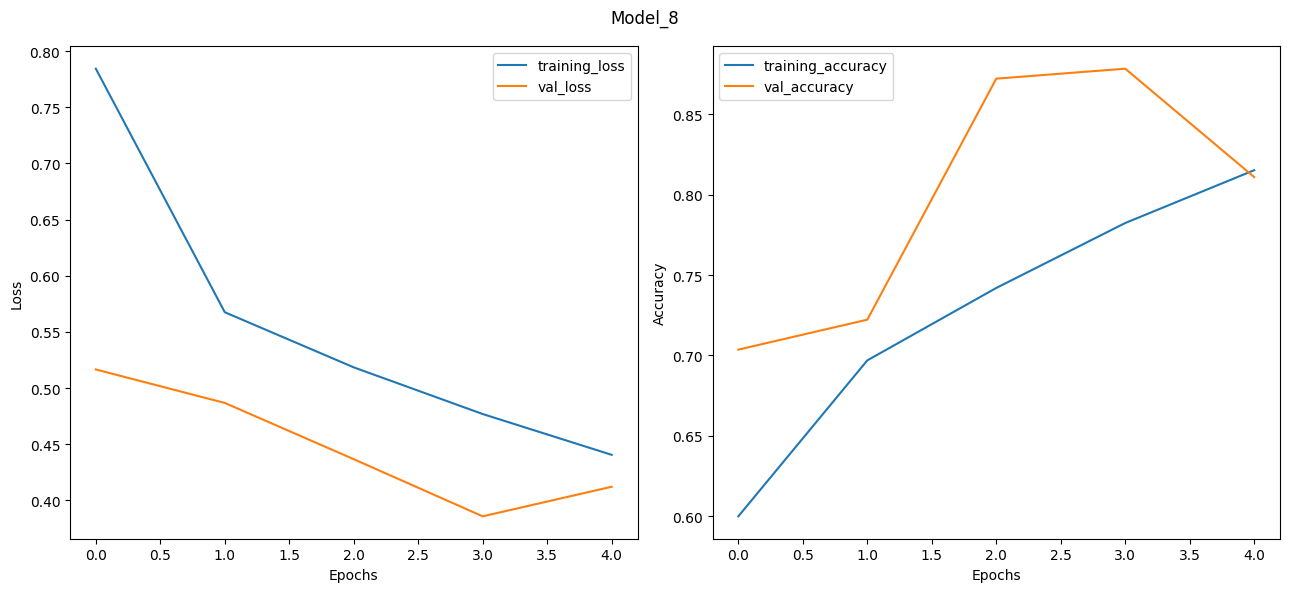

36/36 [==============================] - 3s 89ms/step - loss: 0.4121 - accuracy: 0.8110
Model_9 with:
		-- optimzer:adamax lr_rate:0.0001 --
		-- filters_scale:1.5 activation fun:tanh --
Epoch 1/5
141/141 [==============================] - 83s 585ms/step - loss: 0.7292 - accuracy: 0.6787 - val_loss: 0.4310 - val_accuracy: 0.8066
Epoch 2/5
141/141 [==============================] - 83s 585ms/step - loss: 0.4590 - accuracy: 0.7855 - val_loss: 0.3798 - val_accuracy: 0.8749
Epoch 3/5
141/141 [==============================] - 83s 591ms/step - loss: 0.4244 - accuracy: 0.8046 - val_loss: 0.3519 - val_accuracy: 0.8846
Epoch 4/5
141/141 [==============================] - 83s 591ms/step - loss: 0.3907 - accuracy: 0.8368 - val_loss: 0.3402 - val_accuracy: 0.8651
Epoch 5/5
141/141 [==============================] - 83s 586ms/step - loss: 0.3769 - accuracy: 0.8399 - val_loss: 0.3242 - val_accuracy: 0.8696
=== Training duration is 593.1757659912109 second ===


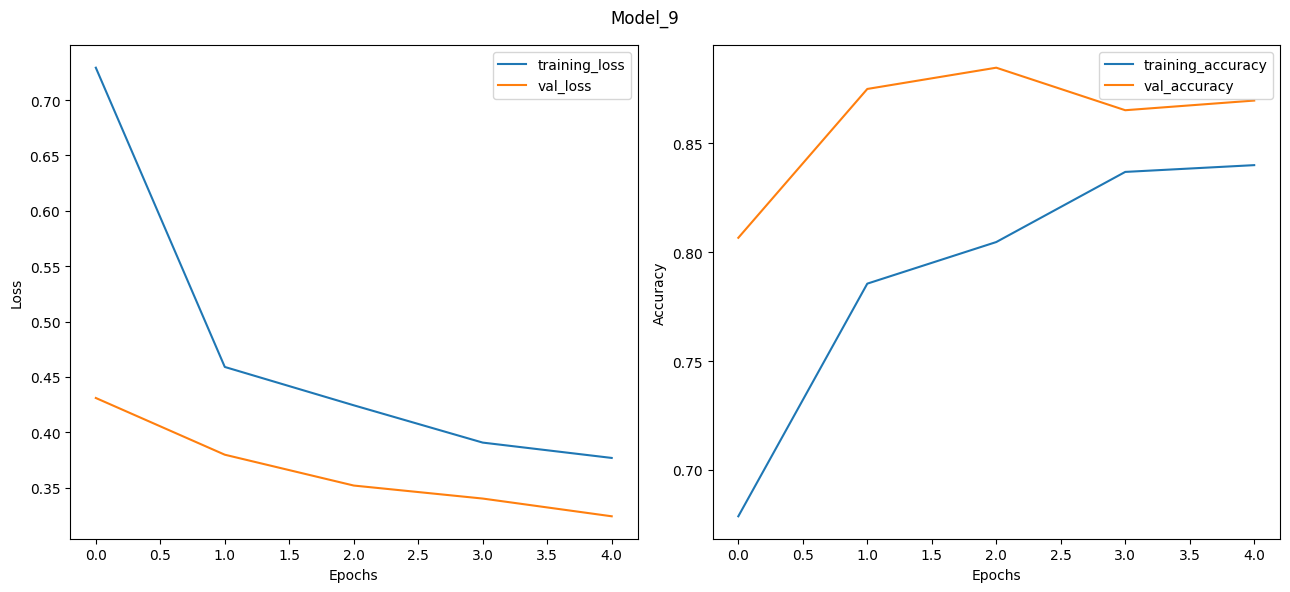

36/36 [==============================] - 3s 84ms/step - loss: 0.3242 - accuracy: 0.8696
Model_10 with:
		-- optimzer:adamax lr_rate:0.0001 --
		-- filters_scale:2 activation fun:relu --
Epoch 1/5
141/141 [==============================] - 86s 602ms/step - loss: 0.6731 - accuracy: 0.6450 - val_loss: 0.4698 - val_accuracy: 0.8509
Epoch 2/5
141/141 [==============================] - 85s 602ms/step - loss: 0.4847 - accuracy: 0.7575 - val_loss: 0.4263 - val_accuracy: 0.8669
Epoch 3/5
141/141 [==============================] - 84s 598ms/step - loss: 0.4228 - accuracy: 0.8219 - val_loss: 0.3696 - val_accuracy: 0.8651
Epoch 4/5
141/141 [==============================] - 85s 598ms/step - loss: 0.3714 - accuracy: 0.8561 - val_loss: 0.3553 - val_accuracy: 0.8465
Epoch 5/5
141/141 [==============================] - 86s 607ms/step - loss: 0.3536 - accuracy: 0.8597 - val_loss: 0.3334 - val_accuracy: 0.8607
=== Training duration is 541.1467995643616 second ===


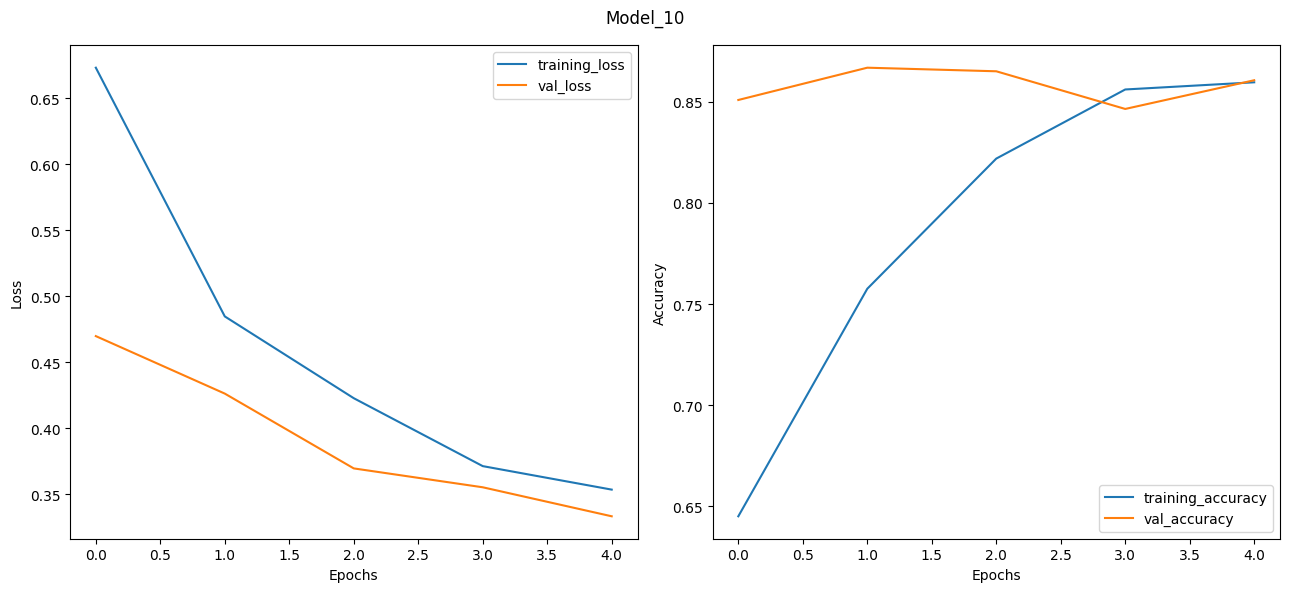

36/36 [==============================] - 3s 82ms/step - loss: 0.3334 - accuracy: 0.8607
Model_11 with:
		-- optimzer:adamax lr_rate:0.0001 --
		-- filters_scale:2 activation fun:tanh --
Epoch 1/5
141/141 [==============================] - 87s 614ms/step - loss: 0.6850 - accuracy: 0.6960 - val_loss: 0.4356 - val_accuracy: 0.7516
Epoch 2/5
141/141 [==============================] - 88s 621ms/step - loss: 0.4390 - accuracy: 0.8037 - val_loss: 0.3826 - val_accuracy: 0.8217
Epoch 3/5
141/141 [==============================] - 88s 620ms/step - loss: 0.3827 - accuracy: 0.8404 - val_loss: 0.3226 - val_accuracy: 0.8713
Epoch 4/5
141/141 [==============================] - 88s 621ms/step - loss: 0.3827 - accuracy: 0.8490 - val_loss: 0.2862 - val_accuracy: 0.8971
Epoch 5/5
141/141 [==============================] - 86s 610ms/step - loss: 0.3289 - accuracy: 0.8772 - val_loss: 0.2884 - val_accuracy: 0.8784
=== Training duration is 601.7905626296997 second ===


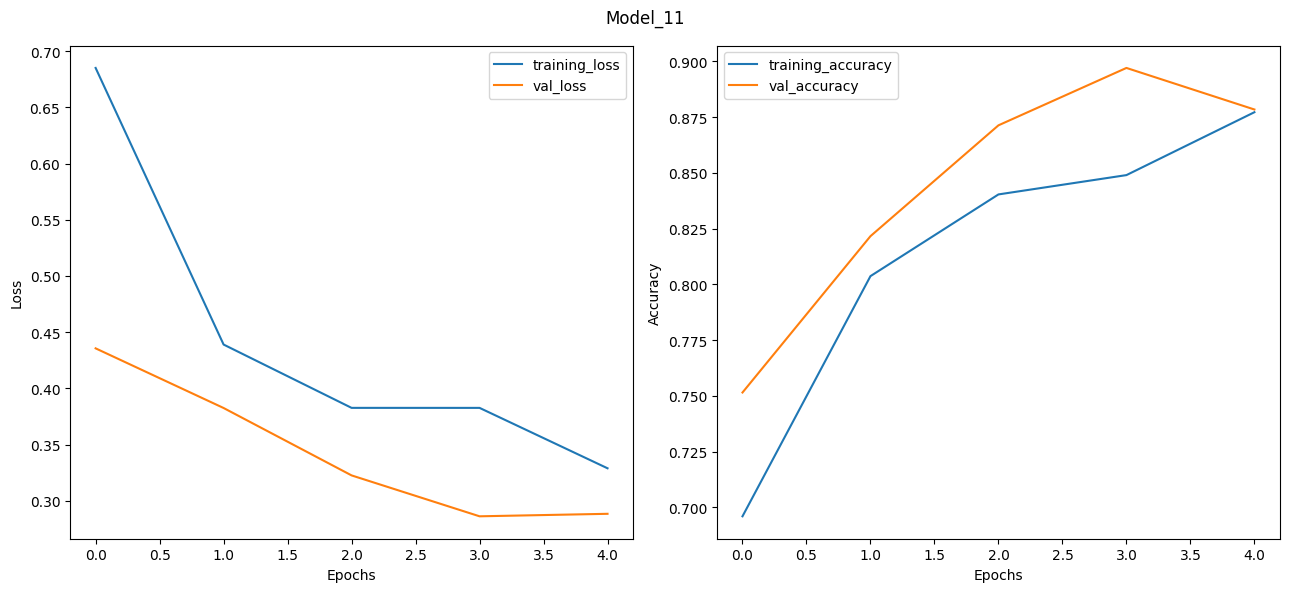

36/36 [==============================] - 4s 101ms/step - loss: 0.2884 - accuracy: 0.8784
Model_12 with:
		-- optimzer:adamax lr_rate:0.0007 --
		-- filters_scale:1.5 activation fun:relu --
Epoch 1/5
141/141 [==============================] - 81s 573ms/step - loss: 0.5593 - accuracy: 0.7229 - val_loss: 0.3887 - val_accuracy: 0.8625
Epoch 2/5
141/141 [==============================] - 79s 558ms/step - loss: 0.3873 - accuracy: 0.8386 - val_loss: 0.3296 - val_accuracy: 0.8616
Epoch 3/5
141/141 [==============================] - 78s 555ms/step - loss: 0.3355 - accuracy: 0.8666 - val_loss: 0.3136 - val_accuracy: 0.8820
Epoch 4/5
141/141 [==============================] - 80s 567ms/step - loss: 0.3342 - accuracy: 0.8632 - val_loss: 0.2937 - val_accuracy: 0.8829
Epoch 5/5
141/141 [==============================] - 81s 577ms/step - loss: 0.3089 - accuracy: 0.8728 - val_loss: 0.2984 - val_accuracy: 0.8713
=== Training duration is 405.25914669036865 second ===


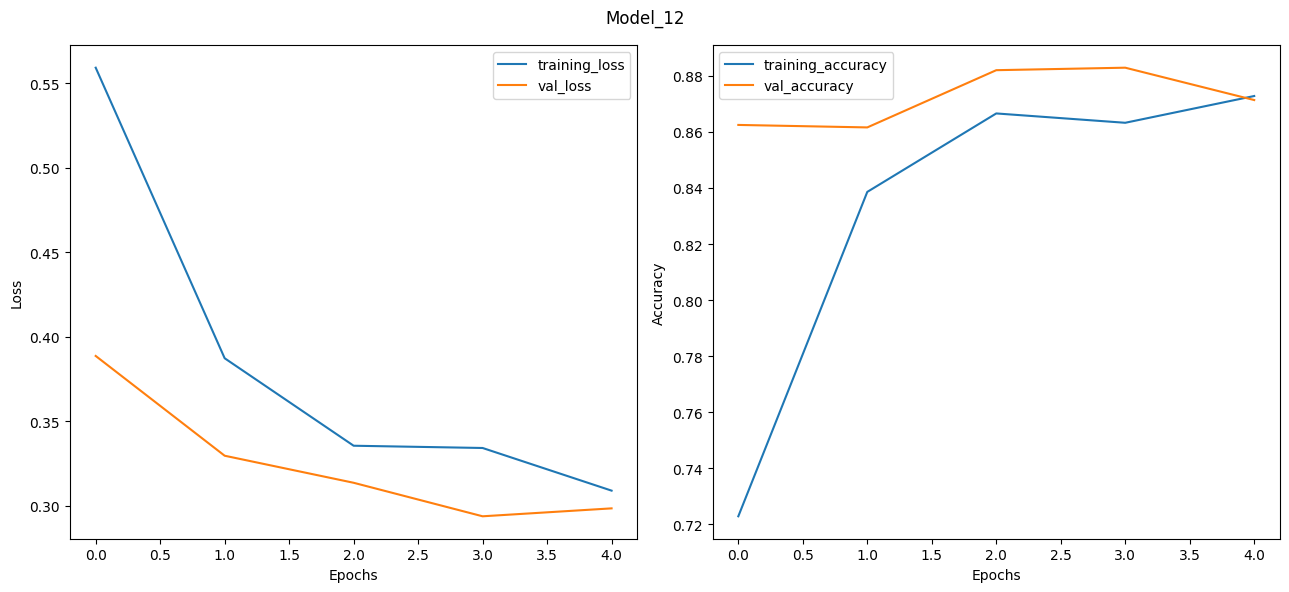

36/36 [==============================] - 3s 78ms/step - loss: 0.2984 - accuracy: 0.8713
Model_13 with:
		-- optimzer:adamax lr_rate:0.0007 --
		-- filters_scale:1.5 activation fun:tanh --
Epoch 1/5
141/141 [==============================] - 83s 585ms/step - loss: 1.0596 - accuracy: 0.6563 - val_loss: 0.4337 - val_accuracy: 0.7782
Epoch 2/5
141/141 [==============================] - 83s 586ms/step - loss: 0.6756 - accuracy: 0.7234 - val_loss: 0.4233 - val_accuracy: 0.8208
Epoch 3/5
141/141 [==============================] - 81s 573ms/step - loss: 0.6483 - accuracy: 0.7313 - val_loss: 0.3710 - val_accuracy: 0.8465
Epoch 4/5
141/141 [==============================] - 84s 594ms/step - loss: 0.6272 - accuracy: 0.7365 - val_loss: 0.4422 - val_accuracy: 0.8004
Epoch 5/5
141/141 [==============================] - 83s 591ms/step - loss: 0.5984 - accuracy: 0.7498 - val_loss: 0.5527 - val_accuracy: 0.7063
=== Training duration is 474.125515460968 second ===


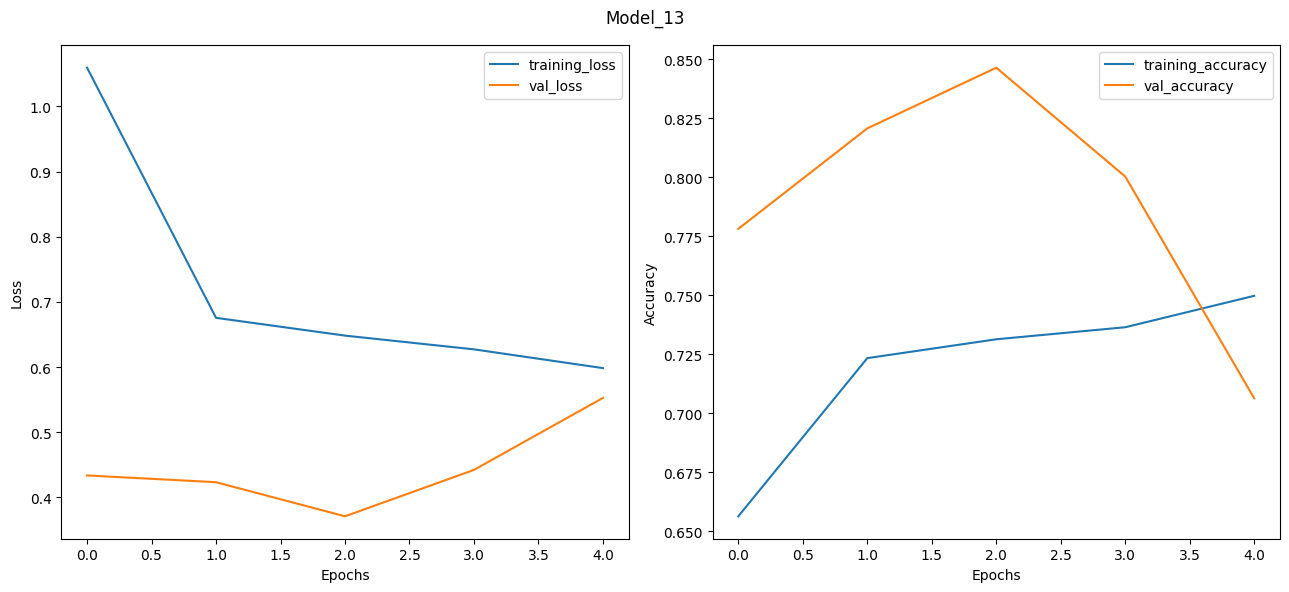

36/36 [==============================] - 3s 88ms/step - loss: 0.5527 - accuracy: 0.7063
Model_14 with:
		-- optimzer:adamax lr_rate:0.0007 --
		-- filters_scale:2 activation fun:relu --
Epoch 1/5
141/141 [==============================] - 86s 606ms/step - loss: 0.6521 - accuracy: 0.7025 - val_loss: 0.3945 - val_accuracy: 0.8474
Epoch 2/5
141/141 [==============================] - 84s 592ms/step - loss: 0.3645 - accuracy: 0.8526 - val_loss: 0.3513 - val_accuracy: 0.8412
Epoch 3/5
141/141 [==============================] - 83s 583ms/step - loss: 0.3772 - accuracy: 0.8437 - val_loss: 0.4328 - val_accuracy: 0.8110
Epoch 4/5
141/141 [==============================] - 85s 602ms/step - loss: 0.3048 - accuracy: 0.8817 - val_loss: 0.2898 - val_accuracy: 0.8731
Epoch 5/5
141/141 [==============================] - 84s 597ms/step - loss: 0.3109 - accuracy: 0.8743 - val_loss: 0.2780 - val_accuracy: 0.8962
=== Training duration is 594.7677593231201 second ===


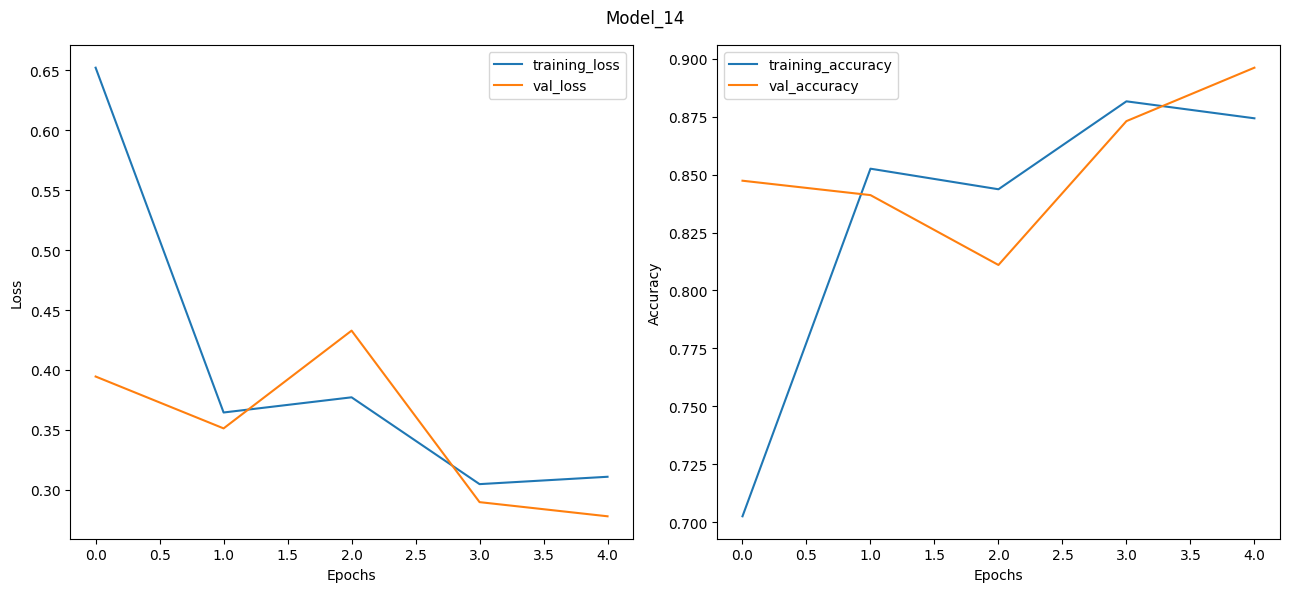

36/36 [==============================] - 4s 98ms/step - loss: 0.2780 - accuracy: 0.8962
Model_15 with:
		-- optimzer:adamax lr_rate:0.0007 --
		-- filters_scale:2 activation fun:tanh --
Epoch 1/5
141/141 [==============================] - 86s 607ms/step - loss: 1.0039 - accuracy: 0.6841 - val_loss: 0.4716 - val_accuracy: 0.8039
Epoch 2/5
141/141 [==============================] - 85s 605ms/step - loss: 0.6583 - accuracy: 0.7231 - val_loss: 0.4181 - val_accuracy: 0.8412
Epoch 3/5
141/141 [==============================] - 86s 610ms/step - loss: 0.6132 - accuracy: 0.7391 - val_loss: 0.4046 - val_accuracy: 0.8447
Epoch 4/5
141/141 [==============================] - 98s 695ms/step - loss: 0.6731 - accuracy: 0.7127 - val_loss: 0.7176 - val_accuracy: 0.6806
Epoch 5/5
141/141 [==============================] - 90s 641ms/step - loss: 0.6364 - accuracy: 0.7254 - val_loss: 0.5827 - val_accuracy: 0.7391
=== Training duration is 542.5672280788422 second ===


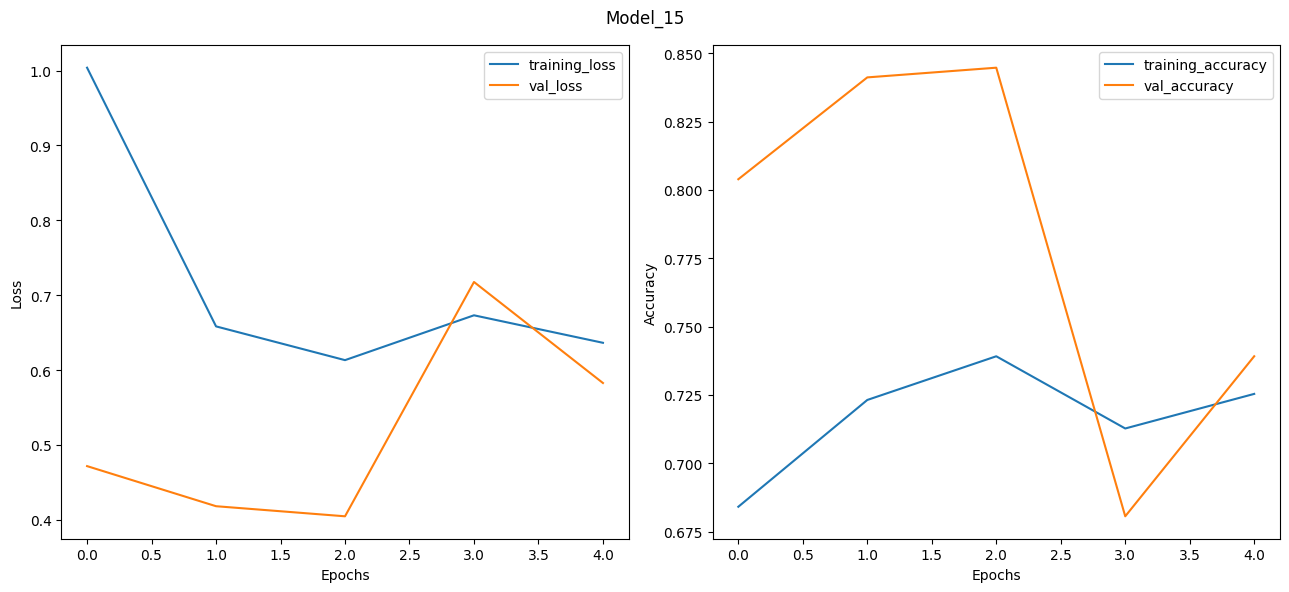

36/36 [==============================] - 4s 111ms/step - loss: 0.5827 - accuracy: 0.7391


In [50]:
model_ids = itertools.count()
for opt, lr_rate, flt_scl, act_fun in itertools.product(optimizers, learning_rates, filters_scale, activation_fun):
    exp_pipeline(train_generator, test_generator, opt, lr_rate, model_ids,
                 epochs, flt_scl, kernels_size, act_fun)

In [51]:
print(exp_results_df)

    model_id optimizer  learning_rate  filters_scale activation_fun  \
0    model_0      adam         0.0001            1.5           relu   
1    model_0      adam         0.0001            1.5           relu   
2    model_0      adam         0.0001            1.5           relu   
3    model_0      adam         0.0001            1.5           relu   
4    model_1      adam         0.0001            1.5           tanh   
5    model_2      adam         0.0001            2.0           relu   
6    model_3      adam         0.0001            2.0           tanh   
7    model_4      adam         0.0007            1.5           relu   
8    model_5      adam         0.0007            1.5           tanh   
9    model_6      adam         0.0007            2.0           relu   
10   model_7      adam         0.0007            2.0           tanh   
11   model_8    adamax         0.0001            1.5           relu   
12   model_9    adamax         0.0001            1.5           tanh   
13  mo

In [52]:
# Save all results to csv
exp_results_df.to_csv("/content/experiments_results.csv")

In [ ]:
# Save Graphs and models to zip and download it
!zip -r /content/figs.zip /content/figs
!zip -r /content/models.zip /content/models

  adding: content/figs/ (stored 0%)
  adding: content/figs/opt-adamax_lr0.0001_fscl2_act-tanh_loss_acc_history.png (deflated 8%)
  adding: content/figs/opt-adam_lr0.0001_fscl2_act-relu_loss_acc_history.png (deflated 10%)
  adding: content/figs/opt-adamax_lr0.0001_fscl1.5_act-relu_loss_acc_history.png (deflated 9%)
  adding: content/figs/opt-adam_lr0.0007_fscl1.5_act-relu_loss_acc_history.png (deflated 9%)
  adding: content/figs/opt-adamax_lr0.0001_fscl2_act-relu_loss_acc_history.png (deflated 9%)
  adding: content/figs/opt-adamax_lr0.0007_fscl2_act-tanh_loss_acc_history.png (deflated 8%)
  adding: content/figs/opt-adam_lr0.0007_fscl2_act-tanh_loss_acc_history.png (deflated 8%)
  adding: content/figs/opt-adam_lr0.0001_fscl2_act-tanh_loss_acc_history.png (deflated 7%)
  adding: content/figs/opt-adamax_lr0.0007_fscl1.5_act-tanh_loss_acc_history.png (deflated 9%)
  adding: content/figs/opt-adamax_lr0.0007_fscl1.5_act-relu_loss_acc_history.png (deflated 10%)
  adding: content/figs/opt-adama

# Using Our Model For Predictions

In [ ]:
from keras.models import load_model
# Load the model
# Define the model save path to load the trained model
model_save_path = f"/content/models/opt-adam_lr{0.0001}_fscl{2}_act-tanh_dl_model.h5"
model = load_model(model_save_path)

In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

# Define the class names
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

In [ ]:
# Load an image from the test set
img = load_img("/content/data/green_area/Forest_1768.jpg", target_size=(255, 255))

In [ ]:
# Convert the image to an array
img_array = img_to_array(img)
img_array

In [ ]:
img_array.shape

In [ ]:
# Normalize the image pixel values to the range [0, 1]
img_array = img_array / 255.0
img_array

In [ ]:

img_array = np.reshape(img_array, (1, 255, 255, 3))

In [ ]:
# Get the model predictions
predictions = model.predict(img_array)

In [ ]:
# Get the class index with the highest predicted probability
class_index = np.argmax(predictions[0])

# Get the predicted class label
predicted_label = class_names[class_index]

print("The image is predicted to be '{}'.".format(predicted_label))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
predictions = model.predict_generator(test_generator)

In [ ]:
predictions

In [ ]:
actual_labels = test_generator.classes

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

In [ ]:
cm = confusion_matrix(actual_labels, predicted_labels)

In [ ]:
print(cm)

In [ ]:
# Confusion matrix

# Plot the confusion matrix as an image
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add the class labels to the plot
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add values to the plot
threshold = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Advanced Predictions From URLs

In [ ]:
from io import BytesIO
import requests
from tensorflow.keras.preprocessing import image
import numpy as np
import tempfile

# Define the class names
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

url_list = ['https://eoimages.gsfc.nasa.gov/images/imagerecords/92000/92263/goldstone_oli_2018124_lrg.jpg',
            'https://images.theconversation.com/files/258323/original/file-20190211-174861-jya1so.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1356&h=668&fit=crop',
            'https://img.freepik.com/free-photo/amazing-beautiful-sky-with-clouds_58702-1657.jpg?w=2000',
            'https://i.natgeofe.com/n/54c007c9-50e5-4cf5-83dc-978a35a4373a/68576_16x9.jpg',
           ]


for url in url_list:
    response = requests.get(url)
    with tempfile.NamedTemporaryFile(mode='wb') as f:
        f.write(response.content)
        f.seek(0)
        img = image.load_img(f.name, target_size=(255, 255))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)

        classes = model.predict(img, batch_size=10)
        class_index = np.argmax(classes[0])
        predicted_label = class_names[class_index]
        print(url + "The image is predicted to be '{}'.".format(predicted_label))
